In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import time
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import os
from sklearn.metrics import confusion_matrix

In [2]:
#SPECTRUM_IMAGES_CLASSES = './data/newSpectrums224/train/'
#SPECTRUM_IMAGES_CLASSES = './data/newFastSpectrums224/train/'
#SPECTRUM_IMAGES_CLASSES = './data/SpecFFT2048hop128Dimen300/train/'
SPECTRUM_IMAGES_CLASSES = '../data/SciPy300/train/'




In [3]:
print(os.listdir(os.curdir))

['PyTorch_Image_Inference.ipynb', 'UrbanSoundTrainingMobileNet.ipynb', 'README.md', 'test.out.npy', 'models', 'GenerateSpectrumUrbanFasterAudio.ipynb', '.ipynb_checkpoints', 'nohup.out', 'test.out', 'genresv1Classes.txt', 'audioExampleNotebook.ipynb', 'GenerateSpectrumUrban.ipynb', '.gitignore', 'GeneratingSpectrums.ipynb', 'UrbanSoundTraining.ipynb', 'cifar10_tutorial.ipynb', 'RealtimeAUdio.py', 'test.npy', '.git', 'GeneratingSpectrumBasedOnGenreFolder.ipynb', 'audio_classifier_tutorial.ipynb', 'data', '.DS_Store', 'PyTorch_Image_Training.ipynb', 'torchTest.py', 'RealtimeAUdio.ipynb']


In [4]:
transform = transforms.Compose(
    [transforms.Resize(224),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



full_dataset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES, transform=transform)
full_DataLoader = torch.utils.data.DataLoader(full_dataset, batch_size=4, shuffle=True, num_workers=2)
train_size = int(0.8 * len(full_dataset))

test_size = len(full_dataset) - train_size

trainset, testset = torch.utils.data.random_split(full_dataset, [train_size, test_size])


#trainset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
classes = full_DataLoader.dataset.classes

print(classes)


['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


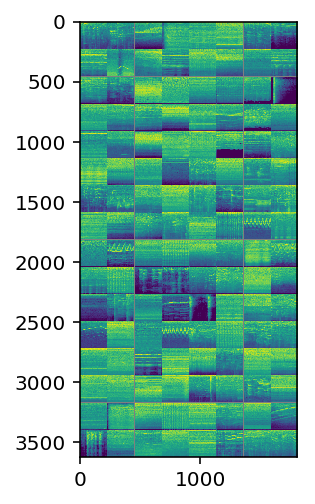

street_music children_playing siren drilling


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
#for i, data in enumerate(trainloader, 0):
    # print the shapes
    #print(np.shape(data[0]))
    #print(i)


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = models.resnet18(pretrained=False)
#model.load_state_dict(torch.load("./models/UrbanSounds"));

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, 1000)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x
model = Net()
print(model)

Net(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False

In [8]:
#model = models.resnet18(pretrained=False)
#model.load_state_dict(torch.load("./models/UrbanSounds"));

In [9]:
print(device)
if device.type=='cuda':
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

cuda


In [10]:
model.train()
train_losses=[]
train_epoch_losses=[]
for epoch in range(100):  # loop over the dataset multiple times
    epochLoss=0.0
    t0 = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        
        epochLoss+=loss.item()
        train_losses.append(loss.item())
        #print(i)    
    print('[%d] loss: %.3f' %  (epoch + 1, epochLoss / len(trainloader)))  # DAVID CHanged it to 1000 from 2000 not sure if thats totally done
    train_epoch_losses.append(epochLoss/len(trainloader))
    print("This Epoch took us: {}".format(time.time()-t0))
print('Finished Training')
torch.save(model.state_dict(), "./models/MobileNetFft2048Hop128.pth")

[1] loss: 4.450
This Epoch took us: 28.22237539291382
[2] loss: 2.409
This Epoch took us: 28.35397505760193
[3] loss: 2.156
This Epoch took us: 28.14663314819336
[4] loss: 1.901
This Epoch took us: 28.218069553375244
[5] loss: 1.645
This Epoch took us: 28.240536212921143
[6] loss: 1.409
This Epoch took us: 28.28469967842102
[7] loss: 1.224
This Epoch took us: 28.20049214363098
[8] loss: 1.058
This Epoch took us: 28.082977771759033
[9] loss: 0.893
This Epoch took us: 28.12209677696228
[10] loss: 0.741
This Epoch took us: 28.199337482452393
[11] loss: 0.621
This Epoch took us: 28.32051134109497
[12] loss: 0.527
This Epoch took us: 28.236854314804077
[13] loss: 0.451
This Epoch took us: 28.099960327148438
[14] loss: 0.384
This Epoch took us: 28.11663508415222
[15] loss: 0.322
This Epoch took us: 28.158798456192017
[16] loss: 0.277
This Epoch took us: 28.171004056930542
[17] loss: 0.237
This Epoch took us: 28.234147787094116
[18] loss: 0.204
This Epoch took us: 28.27995467185974
[19] loss:

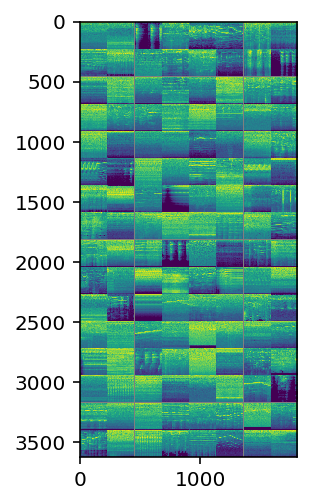

GroundTruth:  engine_idling drilling dog_bark street_music
Predicted:  engine_idling drilling dog_bark street_music


In [11]:
dataiter = iter(testloader)
model.eval()
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
images, labels = images.to(device), labels.to(device)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [12]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
allLabels=[]
allPrediction=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if(len(labels)<4):
            print(c)
        for i in range(4):
            label = labels[i]
            allLabels.append(labels[i].to('cpu').numpy())
            allPrediction.append(predicted[i].to('cpu').numpy())
            class_correct[label] += c[i].item()
            class_total[label] += 1

print(confusion_matrix(allLabels, allPrediction))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[[13  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  1]
 [ 0  0  0  7  1  0  0  0  0  0]
 [ 1  0  0  0 16  1  0  0  1  0]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0 15  0]
 [ 0  0  4  0  0  0  0  0  0 15]]
Accuracy of air_conditioner : 100 %
Accuracy of car_horn : 100 %
Accuracy of children_playing : 90 %
Accuracy of dog_bark : 87 %
Accuracy of drilling : 84 %
Accuracy of engine_idling : 100 %
Accuracy of gun_shot : 100 %
Accuracy of jackhammer : 100 %
Accuracy of siren : 100 %
Accuracy of street_music : 78 %


In [ ]:
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

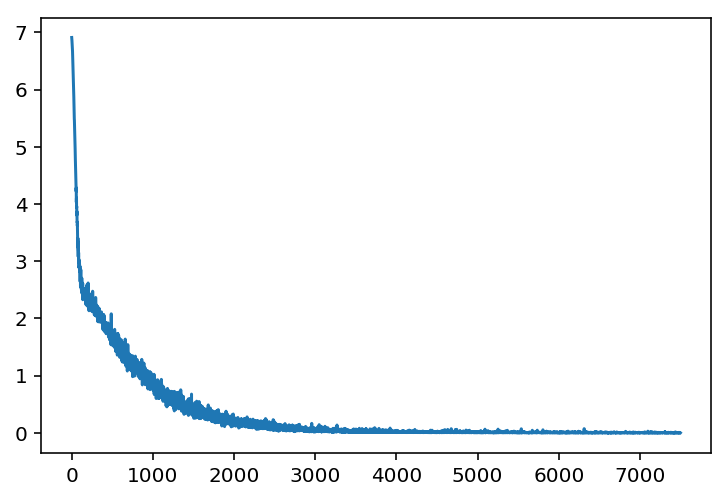

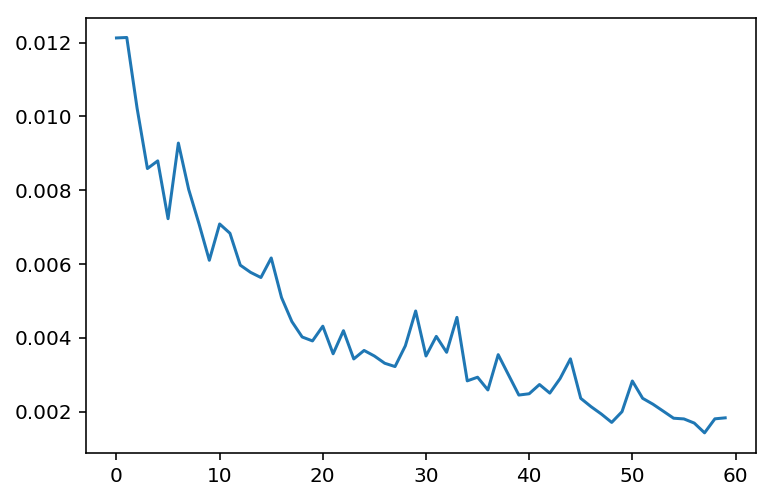

In [14]:
plt.plot(train_losses[:7500], label='Training loss')
plt.show()
plt.plot(train_epoch_losses[40:], label='train_epoch_losses')
#plt.legend(frameon=False)
plt.show()